In [229]:
# Import dependencies
import psycopg2 as pg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import datetime as dt
import tensorflow as tf

In [230]:
# Postgres Connection
engine = pg.connect("dbname='Capstone_Project' user='postgres' host='127.0.0.1' port='5432' password=''")
usaf_df = pd.read_sql("select * from usaf_complete", con=engine)

usaf_df.head()

In [231]:
# Temporary CSV connection to work with model
 
#usaf_df = pd.read_csv("https://raw.githubusercontent.com/CPotts82/Project_Practice/main/usaf_complete.csv")
#usaf_df.head()

,Crash_Date,Crash_Time,Aircraft_SN,Aircraft_Type,Summarized_Name,Ejection_Seats,Base,Wing,Squadron,Mission_Type,...,Longitude,Defense_Type,Defense_Category,Pilot_Hit,Pilot_Rank,Pilot,Pilot_Egress,Pilot_Condition,Pilot_Recovered,Pilot_Status
0,1962-02-11 00:00:00,_,4315732,SC-47A,C-47 Skytrain,N,BHA,_,4400CCTS,NaN,...,107.0,Gunfire (combat associated),Automatic Weapons,_,Capt,Kissam E. K.,Crash,_,_,KIA
1,1962-08-28 00:00:00,_,538376,T-28B,T-28 Trojan,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Simpson R. L.,_,_,_,KIA
2,1962-10-15 00:00:00,_,625909,U-10,U-10 Courier,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Booth H. W.,Crash,_,_,KIA
3,1962-10-16 00:00:00,_,538365,T-28B,T-28 Trojan,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Chambers B. L.,Ejection,Minor injuries,_,Recovered
4,1962-11-05 00:00:00,_,4435530,RB-26B,B-26 Invader,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Bennett R. D.,Crash,_,_,KIA


## Preprocessing the Data


In [271]:
# Create dataframe with variables for model

nn_model = usaf_df.filter(['Crash_Date','Summarized_Name', 'Defense_Category', 'Ejection_Seats', 'Pilot_Egress', 'Latitude', 'Longitude', 'Pilot_Status'], axis=1)

nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status
0,1962-02-11 00:00:00,C-47 Skytrain,Automatic Weapons,N,Crash,11.75,107.0,KIA
1,1962-08-28 00:00:00,T-28 Trojan,Automatic Weapons,N,_,NaN,NaN,KIA
2,1962-10-15 00:00:00,U-10 Courier,Automatic Weapons,N,Crash,NaN,NaN,KIA
3,1962-10-16 00:00:00,T-28 Trojan,Automatic Weapons,N,Ejection,NaN,NaN,Recovered
4,1962-11-05 00:00:00,B-26 Invader,Automatic Weapons,N,Crash,NaN,NaN,KIA


In [272]:
# Convert Crash_Date to datetime data type
nn_model["Crash_Date"] = pd.to_datetime(nn_model["Crash_Date"])
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status
0,1962-02-11,C-47 Skytrain,Automatic Weapons,N,Crash,11.75,107.0,KIA
1,1962-08-28,T-28 Trojan,Automatic Weapons,N,_,NaN,NaN,KIA
2,1962-10-15,U-10 Courier,Automatic Weapons,N,Crash,NaN,NaN,KIA
3,1962-10-16,T-28 Trojan,Automatic Weapons,N,Ejection,NaN,NaN,Recovered
4,1962-11-05,B-26 Invader,Automatic Weapons,N,Crash,NaN,NaN,KIA


In [273]:
# Check to see what years are present in converted dates
nn_model["Crash_Date"].dt.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973])

In [274]:
# Check data type to ensure date conversion
nn_model.dtypes

Crash_Date          datetime64[ns]
Summarized_Name             object
Defense_Category            object
Ejection_Seats              object
Pilot_Egress                object
Latitude                   float64
Longitude                  float64
Pilot_Status                object
dtype: object

In [275]:
# Drop null values for Latitude and Longitude columns
nn_model = nn_model.dropna(subset = ['Latitude', 'Longitude'])
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status
0,1962-02-11,C-47 Skytrain,Automatic Weapons,N,Crash,11.750000,107.000000,KIA
29,1964-09-22,A-1 Skyraider,AAA,Y,Crashlanded,9.500000,105.583333,KIA
30,1964-09-22,A-1 Skyraider,AAA,Y,Ejection,9.500000,105.583333,Recovered
31,1964-09-26,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,10.083333,106.066667,Recovered
32,1964-10-02,A-1 Skyraider,Automatic Weapons,Y,Crash,9.566667,106.450000,KIA


In [277]:
# Check for '_' string values

#nn_model.loc[nn_model["Pilot_Egress"] == '_'].count()
#nn_model.loc[nn_model["Crash_Date"] == '_'].count()
#nn_model.loc[nn_model["Summarized_Name"] == '_'].count()
#nn_model.loc[nn_model["Defense_Category"] == '_'].count()
#nn_model.loc[nn_model["Ejection_Seats"] == '_'].count()
#nn_model.loc[nn_model["Latitude"] == '_'].count()
#nn_model.loc[nn_model["Longitude"] == '_'].count()
nn_model.loc[nn_model["Pilot_Status"] == '_'].count()

Crash_Date          2
Summarized_Name     2
Defense_Category    2
Ejection_Seats      2
Pilot_Egress        2
Latitude            2
Longitude           2
Pilot_Status        2
dtype: int64

In [279]:
# Remove rows that have string value "_".

nn_model = nn_model[(nn_model.Pilot_Egress != '_') & (nn_model.Pilot_Status != '_')]
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status
0,1962-02-11,C-47 Skytrain,Automatic Weapons,N,Crash,11.750000,107.000000,KIA
29,1964-09-22,A-1 Skyraider,AAA,Y,Crashlanded,9.500000,105.583333,KIA
30,1964-09-22,A-1 Skyraider,AAA,Y,Ejection,9.500000,105.583333,Recovered
31,1964-09-26,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,10.083333,106.066667,Recovered
32,1964-10-02,A-1 Skyraider,Automatic Weapons,Y,Crash,9.566667,106.450000,KIA


In [280]:
# Check to ensure '_' values have been dropped
nn_model.loc[nn_model["Pilot_Status"] == '_'].count()

Crash_Date          0
Summarized_Name     0
Defense_Category    0
Ejection_Seats      0
Pilot_Egress        0
Latitude            0
Longitude           0
Pilot_Status        0
dtype: int64

In [281]:
# Determine the number of unique values in each column.
nn_model.nunique()

Crash_Date          831
Summarized_Name      26
Defense_Category      7
Ejection_Seats        2
Pilot_Egress          6
Latitude            486
Longitude           338
Pilot_Status         14
dtype: int64

In [282]:
# Instead of binning by Crash_Date - Create a new column, Crash_Year, in the dataframe
nn_model['Crash_Year'] = pd.DatetimeIndex(nn_model['Crash_Date']).year
nn_model.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status,Crash_Year
0,1962-02-11,C-47 Skytrain,Automatic Weapons,N,Crash,11.750000,107.000000,KIA,1962
29,1964-09-22,A-1 Skyraider,AAA,Y,Crashlanded,9.500000,105.583333,KIA,1964
30,1964-09-22,A-1 Skyraider,AAA,Y,Ejection,9.500000,105.583333,Recovered,1964
31,1964-09-26,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,10.083333,106.066667,Recovered,1964
32,1964-10-02,A-1 Skyraider,Automatic Weapons,Y,Crash,9.566667,106.450000,KIA,1964


In [283]:
# Drop Crash_Date column - will only use Crash_Year in model
nn_model.drop(['Crash_Date'], axis = 1, inplace=True)
nn_model.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status,Crash_Year
0,C-47 Skytrain,Automatic Weapons,N,Crash,11.750000,107.000000,KIA,1962
29,A-1 Skyraider,AAA,Y,Crashlanded,9.500000,105.583333,KIA,1964
30,A-1 Skyraider,AAA,Y,Ejection,9.500000,105.583333,Recovered,1964
31,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,10.083333,106.066667,Recovered,1964
32,A-1 Skyraider,Automatic Weapons,Y,Crash,9.566667,106.450000,KIA,1964


In [284]:
# Check Crash_Year value counts for binning by year (if necessary)
year_counts = nn_model.Crash_Year.value_counts()
year_counts

1967    239
1966    229
1968    210
1969    126
1965     94
1970     87
1972     83
1971     50
1973      8
1964      7
1962      1
Name: Crash_Year, dtype: int64

In [285]:
# Look at Summarized_Name value counts for binning
name_counts = nn_model.Summarized_Name.value_counts()
name_counts

F-4 Phantom            289
F-105 Thunderchief     272
F-100 Super Sabre      160
A-1 Skyraider          131
O-1 Bird Dog            61
O-2 Skymaster           49
OV-10 Bronco            31
B-57 Canberra           22
F-101 Voodoo            21
C-130 Hercules          19
C-123 Provider          11
AC-47 Gunship I         10
A-37 Dragonfly          10
F-104 Starfighter        8
C-7 Caribou              7
A-26 Invader             6
F-5 Tiger                6
B-52 Stratofortress      5
C-47 Skytrain            4
B-66 Destroyer           3
A-7 Corsair              3
T-28 Trojan              2
F-102 Delta Dagger       1
HU-16 Albatross          1
C-119 Flying Boxcar      1
F-111 Aardvark           1
Name: Summarized_Name, dtype: int64

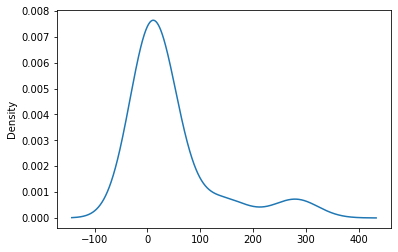

In [286]:
# Visualize the value counts of Summarized_Name
name_counts.plot.density()

In [287]:
# Determine which values to replace if counts are less than ...?
replace_names = list(name_counts[name_counts < 18].index)

# Replace in dataframe
for name in replace_names:
    nn_model.Summarized_Name = nn_model.Summarized_Name.replace(name,"Other")
    
# Check to make sure binning was successful
nn_model.Summarized_Name.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


F-4 Phantom           289
F-105 Thunderchief    272
F-100 Super Sabre     160
A-1 Skyraider         131
Other                  79
O-1 Bird Dog           61
O-2 Skymaster          49
OV-10 Bronco           31
B-57 Canberra          22
F-101 Voodoo           21
C-130 Hercules         19
Name: Summarized_Name, dtype: int64

In [294]:
# Look at Pilot_Status value counts for categories
pilot_counts = nn_model.Pilot_Status.value_counts()
pilot_counts

Recovered                  575
KIA                        337
POW (returned)             148
MIA                         54
POW (died)                   6
POW                          3
KIA (chute failure)          3
Recoverd                     2
KIA (chute failed)           1
Recovered DaNang             1
POW (died in captivity)      1
Recovered (chute fail)       1
recovered                    1
KIA,body MIA,PJ abandnd      1
Name: Pilot_Status, dtype: int64

In [295]:
# Clean the Target variable - Create binomial

status = {'Recovered': 1, 'KIA': 0,'POW (returned)': 1,'MIA': 0,'POW (died)': 0,'POW': 1,'KIA (chute failure)': 0,'Recoverd': 1, 'u': 0, 
    'KIA (chute failed)': 0, 'Recovered DaNang': 1, 'POW (died in captivity)':0, 'Recovered (chute fail)': 1,'recovered': 1,'KIA,body MIA,PJ abandnd': 1, 'POW (died in captivity)': 0}

nn_df = nn_model.replace({"Pilot_Status": status})
nn_df.head(10)

,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Latitude,Longitude,Pilot_Status,Crash_Year
0,Other,Automatic Weapons,N,Crash,11.750000,107.000000,0,1962
29,A-1 Skyraider,AAA,Y,Crashlanded,9.500000,105.583333,0,1964
30,A-1 Skyraider,AAA,Y,Ejection,9.500000,105.583333,1,1964
31,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,10.083333,106.066667,1,1964
32,A-1 Skyraider,Automatic Weapons,Y,Crash,9.566667,106.450000,0,1964
34,A-1 Skyraider,Automatic Weapons,Y,Crash,10.800000,106.583333,0,1964
38,A-1 Skyraider,Automatic Weapons,Y,Ejection,11.300000,106.900000,1,1964
39,O-1 Bird Dog,Other,N,Ejection,16.133333,107.900000,0,1964
41,F-105 Thunderchief,AAA,Y,Ejection,19.583333,103.666667,1,1965
44,A-1 Skyraider,Automatic Weapons,Y,Crashlanded,9.566667,106.583333,1,1965


In [296]:
nn_model.dtypes

Summarized_Name      object
Defense_Category     object
Ejection_Seats       object
Pilot_Egress         object
Latitude            float64
Longitude           float64
Pilot_Status         object
Crash_Year            int64
dtype: object

In [297]:
# Determine the number of unique values in each column after binning and adding Crash_Year
nn_df.nunique()

Summarized_Name      11
Defense_Category      7
Ejection_Seats        2
Pilot_Egress          6
Latitude            486
Longitude           338
Pilot_Status          2
Crash_Year           11
dtype: int64

In [298]:
# Generate our categorical variable lists
nn_cat = nn_df.dtypes[nn_df.dtypes == "object"].index.tolist()
nn_cat

['Summarized_Name', 'Defense_Category', 'Ejection_Seats', 'Pilot_Egress']

In [299]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(nn_df[nn_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(nn_cat)
encode_df.head()

,Summarized_Name_A-1 Skyraider,Summarized_Name_B-57 Canberra,Summarized_Name_C-130 Hercules,Summarized_Name_F-100 Super Sabre,Summarized_Name_F-101 Voodoo,Summarized_Name_F-105 Thunderchief,Summarized_Name_F-4 Phantom,Summarized_Name_O-1 Bird Dog,Summarized_Name_O-2 Skymaster,Summarized_Name_OV-10 Bronco,...,Defense_Category_SAM,Defense_Category_Small Arms Fire,Ejection_Seats_N,Ejection_Seats_Y,Pilot_Egress_Crash,Pilot_Egress_Crashlanded,Pilot_Egress_Crld at AB,Pilot_Egress_Crld at UBN,Pilot_Egress_Crld at UDN,Pilot_Egress_Ejection
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [300]:
# Merge one-hot encoded features and drop the originals
nn_df = nn_df.merge(encode_df, left_index=True, right_index=True)
nn_df = nn_df.drop(nn_cat, 1)
nn_df.head(25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Latitude,Longitude,Pilot_Status,Crash_Year,Summarized_Name_A-1 Skyraider,Summarized_Name_B-57 Canberra,Summarized_Name_C-130 Hercules,Summarized_Name_F-100 Super Sabre,Summarized_Name_F-101 Voodoo,Summarized_Name_F-105 Thunderchief,...,Defense_Category_SAM,Defense_Category_Small Arms Fire,Ejection_Seats_N,Ejection_Seats_Y,Pilot_Egress_Crash,Pilot_Egress_Crashlanded,Pilot_Egress_Crld at AB,Pilot_Egress_Crld at UBN,Pilot_Egress_Crld at UDN,Pilot_Egress_Ejection
0,11.750000,107.000000,0,1962,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29,9.500000,105.583333,0,1964,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30,9.500000,105.583333,1,1964,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
31,10.083333,106.066667,1,1964,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
32,9.566667,106.450000,0,1964,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
34,10.800000,106.583333,0,1964,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
38,11.300000,106.900000,1,1964,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39,16.133333,107.900000,0,1964,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41,19.583333,103.666667,1,1965,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
44,9.566667,106.583333,1,1965,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [301]:
# Check to ensure total number of rows meets 1000 row min criteria
print(nn_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847 entries, 0 to 1133
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Latitude                            847 non-null    float64
 1   Longitude                           847 non-null    float64
 2   Pilot_Status                        847 non-null    int64  
 3   Crash_Year                          847 non-null    int64  
 4   Summarized_Name_A-1 Skyraider       847 non-null    float64
 5   Summarized_Name_B-57 Canberra       847 non-null    float64
 6   Summarized_Name_C-130 Hercules      847 non-null    float64
 7   Summarized_Name_F-100 Super Sabre   847 non-null    float64
 8   Summarized_Name_F-101 Voodoo        847 non-null    float64
 9   Summarized_Name_F-105 Thunderchief  847 non-null    float64
 10  Summarized_Name_F-4 Phantom         847 non-null    float64
 11  Summarized_Name_O-1 Bird Dog        847 non-

## Process Data 

In [302]:
# Split our preprocessed data into our features and target arrays
y = nn_df["Pilot_Status"].values 
X = nn_df.drop(["Pilot_Status"], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [303]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [304]:
len(X_train[0])

29

In [335]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 3
hidden_nodes_layer2 = 3
hidden_nodes_layer3 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 3)                 90        
                                                                 
 dense_18 (Dense)            (None, 3)                 12        
                                                                 
 dense_19 (Dense)            (None, 4)                 16        
                                                                 
 dense_20 (Dense)            (None, 1)                 5         
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [336]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [337]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [338]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period = 5
    )

In [339]:
# Train the model
fit_model = nn.fit(X_train, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
20/20 [==============================] - 1s 2ms/step - loss: 0.6557 - accuracy: 0.6504
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.6504
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6518 - accuracy: 0.6504
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.6504
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 0.6696 - accuracy: 0.6250
Epoch 5: saving model to checkpoints/weights.05.hdf5
20/20 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6504
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6504
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6504
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.6504
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss:

In [340]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

7/7 - 0s - loss: 0.6346 - accuracy: 0.6651 - 145ms/epoch - 21ms/step
Loss: 0.6345634460449219, Accuracy: 0.6650943160057068
